In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
metadata = pd.read_excel("../fig1/table_s1.xlsx", sheet_name="Clinical_data")
samples_105 = list(i.strip() for i  in open("../fig7/sample105.list").readlines())
samples_41 = metadata[(metadata["tumor_included_for_the_study"]== "yes") & 
                      (metadata["normal_included_for_the_study"]=="yes") & 
                      (metadata["case_id"].isin(samples_105)) &
                      (metadata["histology_diagnosis"] == "PDAC")
                      ]["case_id"].to_list()
samples_100 = metadata[(metadata["histology_diagnosis"]=="PDAC") & (metadata["case_id"].isin(samples_105))]["case_id"].to_list()

In [4]:
# glycoprotein list
glyco_tumor = pd.read_csv("../data_linkedomics/N-glycoproteomics_peptide_level_ratio_tumor.cct", 
                        sep="\t", na_values = "NA")
glyco_tumor = glyco_tumor.set_index(["Gene","Sequence"]).sort_index()
glyco_normal = pd.read_csv("../data_linkedomics/N-glycoproteomics_peptide_level_ratio_normal.cct", 
                        sep="\t", na_values = "NA")
glyco_normal = glyco_normal.set_index(["Gene","Sequence"]).sort_index()
glyco_tumor = glyco_tumor[samples_100]
glyco_normal = glyco_normal[samples_41]
glyco = pd.concat([glyco_tumor, glyco_normal], axis =1)
glycoproteins =  glyco[glyco.notna().sum(axis =1) > 0].index.get_level_values(0).str.split("-").str[0].unique().to_list()
len(glycoproteins)
# glycoproteins =  glyco[glyco.notna().sum(axis =1) > 0].index.get_level_values(0).unique().to_list()

1107

In [5]:
normal_prot = pd.read_csv("../data_linkedomics/proteomics_gene_level_MD_abundance_normal.cct",
                        sep="\t", na_values = "NA", index_col=0)
tumor_prot = pd.read_csv("../data_linkedomics/proteomics_gene_level_MD_abundance_tumor.cct",
                        sep="\t", na_values = "NA", index_col=0)
# normal_prot.index = normal_prot.index.str.split("-").str[0]
# tumor_prot.index = tumor_prot.index.str.split("-").str[0]
### Sort columns 
normal_prot = normal_prot[samples_41]
tumor_prot = tumor_prot[samples_100]
normal_prot = normal_prot[sorted(normal_prot.columns)]
tumor_prot = tumor_prot[sorted(tumor_prot.columns)]
print(tumor_prot.shape, normal_prot.shape)

# # filter index of normal and tumor matrices
normal_mat = normal_prot.index[normal_prot.index.isin(glycoproteins)]
tumor_mat = tumor_prot.index[tumor_prot.index.isin(glycoproteins)]
normal_mat = normal_prot.loc[normal_mat]
tumor_mat = tumor_prot.loc[tumor_mat]

print(normal_mat.shape, tumor_mat.shape)


(11662, 100) (11662, 41)
(1020, 41) (1020, 100)


In [7]:
combined = pd.concat([tumor_mat, normal_mat], axis=1)
valid_proteins = combined.notna().mean(axis=1) >= 0.5

tumor_filtered = tumor_mat[valid_proteins]
normal_filtered = normal_mat[valid_proteins]

fc = tumor_filtered.median(axis =1) - normal_filtered.median(axis =1)

p_values = []
log2fc_values = []
for gene in tumor_filtered.index:
    log2fc_values.append(fc.loc[gene])
    stat, p = ranksums(tumor_filtered.loc[gene].dropna(), normal_filtered.loc[gene].dropna())
    p_values.append(p)
reject, fdr_values, _, _ = multipletests(p_values, method="fdr_bh")
results_df = pd.DataFrame({
    "Name": tumor_filtered.index,
    "log2FC": log2fc_values,
    "p_value": p_values,
    "FDR": fdr_values,
    "significant": reject,
    "log10(FDR)": -np.log10(fdr_values)
}).set_index("Name")


In [12]:
results_df

# results_df.to_csv("fig4a_glycoprotein_tumor_nat.tsv", sep="\t")

,log2FC,p_value,FDR,significant,log10(FDR)
Name,,,,,
A1BG,0.504083,9.578040e-06,2.016189e-05,True,4.695469
A2M,0.358314,7.909897e-03,1.136243e-02,True,1.944529
A2ML1,0.436528,5.104884e-04,8.431662e-04,True,3.074087
AADAC,-1.106707,5.174870e-06,1.132565e-05,True,4.945937
ABCA1,0.365131,2.252676e-01,2.591990e-01,False,0.586367
...,...,...,...,...,...
WNT5A,0.815410,2.437143e-08,7.512897e-08,True,7.124193
YBX3,-0.866932,2.343242e-11,1.445272e-10,True,9.840050
YTHDF3,-0.154635,5.886964e-04,9.597602e-04,True,3.017837


In [326]:
print((fc>1).sum())
print((fc<-1).sum())

75
41


## Plot

In [342]:
supdata = pd.read_excel("mmc4.xlsx", sheet_name="Glycoprotien_Tumor_vs_NAT", index_col = 0)
results_df["Cellular_Location"] = results_df.index.map(supdata["Cellular_Location"])

results_df["Category"] = pd.cut(results_df["log2FC"], 
                             bins=[-float('inf'), -1, 0, 1, float('inf')],
                             labels=[">2X Down", "Down", "Up", ">2X Up"])
results_df["Category"] = results_df["Category"].cat.add_categories("NS")
results_df.loc[results_df["FDR"] >= 0.01, "Category"] = "NS"
results_df.head(3)

,log2FC,p_value,FDR,significant,log10(FDR),Cellular_Location,Category
Name,,,,,,,
A1BG,0.504083,0.00001,0.000020,True,4.695469,Secreted(blood),Up
A2M,0.358314,0.00791,0.011362,True,1.944529,Secreted(blood),NS
A2ML1,0.436528,0.00051,0.000843,True,3.074087,Other,Up


18


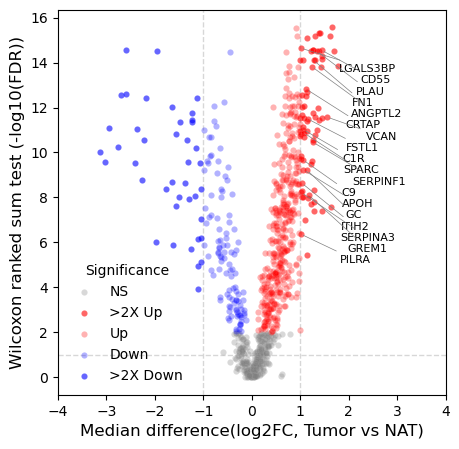

In [349]:
plt.figure(figsize=(5,5))
cat_settings = {
    "NS": {"color": "gray", "alpha": 0.3},
    ">2X Up": {"color": "red", "alpha": 0.6},
    "Up": {"color": "red", "alpha": 0.3},
    "Down": {"color": "blue", "alpha": 0.3},
    ">2X Down": {"color": "blue", "alpha": 0.6},
}
cnt =0
# 카테고리별로 scatterplot 개별 호출
for cat, props in cat_settings.items():
    subset = results_df[results_df["Category"] == cat]
    sns.scatterplot(
        data=subset,
        x='log2FC',
        y='log10(FDR)',
        color=props["color"],
        label=cat,
        alpha=props["alpha"],
        s=20,
        edgecolor="white",
        linewidth=0.1
    )
    if cat == ">2X Up":
        secreted_subset = subset[subset["Cellular_Location"] == "Secreted(blood)"]
        # Sort by adjusted_p
        secreted_subset = secreted_subset.sort_values(by="FDR", ascending=True)
        
        for _, row in secreted_subset.iterrows():
            cnt+=1
            plt.annotate(
                text=row.name,
                xy=(row["log2FC"], row['log10(FDR)']),
                # xytext=(row["log2FC"] + 1, row['"-LOG10(adjusted_p)"'] + 0.5),
                xytext=(row["log2FC"] + 0.8, 14-cnt *0.5),
                textcoords='data',
                fontsize=8,
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
                horizontalalignment='left',
                verticalalignment='bottom'
            )
print(cnt)

plt.legend(title="Category")
plt.xlim(-4,4)
plt.xlabel("Median difference(log2FC, Tumor vs NAT)", fontsize = 12)
plt.ylabel("Wilcoxon ranked sum test (-log10(FDR))", fontsize = 12)
plt.legend(frameon = False, title = "Significance")

# Draw line
plt.axhline(y=1, color='lightgray', linestyle='--', linewidth=1, alpha = 0.9, zorder = 0 )
plt.axvline(x=1, color='lightgray', linestyle='--', linewidth=1, alpha = 0.9, zorder = 0 )
plt.axvline(x=-1, color='lightgray', linestyle='--', linewidth=1, alpha = 0.9, zorder = 0 )
